# Training UNet for drop segmentation

In [78]:
import torch
from checkpoints import *
from measures import *

In [79]:
config = {
    "lr": 0.001,
    "batch_size": 16,
    "epochs": 15,
    "threshold": 0.3,
    "init_from_checkpoint": False,
    "input_mode": "RGBS",
    "image_dir": '../../data/derain/ALIGNED_PAIRS/CG_DROPLETS',
    "mask_dir": '../../data/derain/ALIGNED_PAIRS/CG_MASKS',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "cg_checkpoints",
    "checkpoint": "UNetRGBDBCEt13v13e27.pt", # if None loads last saved checkpoint
    "print_model": False,
    "binarization": True,
    "seed": 3407 # if None uses random seed
}
config["channels"] = len(config["input_mode"])
print(f"Training using {config['device']}")

Training using cuda


In [80]:
# Set seed
if config["seed"] is not None:
    torch.manual_seed(config["seed"])  

In [81]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
import dataset
importlib.reload(dataset)
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    mode=config["input_mode"],
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    binarization = config["binarization"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 4812 images

Train: 4331 images, 271 batches
Val: 481 images, 31 batches


In [82]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet, RUNet
from unet import init_weights
from pathlib import Path
from torch.optim import lr_scheduler

model = UNet(config["channels"]).to(config['device'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=config["lr"])

# Load or fill weights
# And set the start_epoch of model
if config["init_from_checkpoint"]:
    # Load checkpoint
    if config["checkpoint"] is None:
        path = last_checkpoint(config["checkpoint_dir"])
    else:
        path = Path(config["checkpoint_dir"], config["checkpoint"])     
    checkpoint = torch.load(path)
    
    # Load model & optim from checkpoint
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"Loaded parameters from '{path}'")
    print_checkpoint(checkpoint)
    start_epoch = checkpoint["epochs"]
else:
    init_weights(model, torch.nn.init.normal_, mean=0., std=1)
    print("Randomly initiated parameters")
    start_epoch = 0

scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=3,
    gamma=0.8
)

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

layers = model.train()
if config["print_model"]:
    print(layers)

Randomly initiated parameters


In [83]:
def validate(model, loss_fn):
    import math
    model.eval()

    losses = []
    accuracies = []
    precisions = []
    recalls = []
    ious = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            pred = model(x)
            loss = loss_fn(pred, y)
            
            
            if not math.isnan(loss.item()):
                losses.append(loss.item())
            else:
                print("Nan on validation")
            
            pred = torch.sigmoid(model(x))
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            if config["binarization"]:
                pred = (pred >= config["threshold"])
            
            accuracies.append(accuracy(y, pred))
            ious.append(IoU(y, pred))
            precisions.append(precision(y, pred))
            recalls.append(recall(y, pred))
    model.train()         
    mean = lambda l: sum(l) / len(l) if len(l) > 0 else -1
    return mean(losses), mean(ious), mean(accuracies), mean(precisions), mean(recalls)

In [84]:
def ch_score(checkpoint):
    return checkpoint["iou"]

In [85]:
best_checkpoint = {
    "name": "nullcheck",
    "epochs": 0,
    "model_state_dict": [],
    "optimizer_state_dict": [],
    "train_loss": 1e100,
    "val_loss": 1e100,
    "iou": 0,
    "accuracy": 0,
    "precision": 0,
    "recall": 0
}

In [86]:
from tqdm.notebook import tqdm
from sys import stdout
import math
def train(save_checkpoints=True, lr=None):
    # If lr=None, learning rate is used from optimizer
    if lr is not None:
        optimizer.param_groups[0]["lr"] = lr
    global best_checkpoint
    
    for epoch in range(config['epochs']):
        epoch += start_epoch
        print("Epoch", epoch, "| lr", optimizer.state_dict()["param_groups"][0]["lr"])
        
        loader = tqdm(train_loader)
        losses = []

        # Training this epoch
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                if math.isnan(torch.max(pred)):
                    print(f"NaN pred occured")
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            train_loss = loss.item()
            if math.isnan(train_loss):
                print(f"NaN loss occured")
                return
            
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)
            
        optimizer.step()
        scheduler.step()


        # Compute metrics
        train_loss = sum(losses) / len(losses)
        checkpoint = get_checkpoint( 
                model,
                config["input_mode"],
                optimizer,
                loss_fn,
                epoch,
                train_loss,
                *validate(model, loss_fn)
            )
        print_checkpoint(checkpoint)
        
        if save_checkpoints:
            save_checkpoint(
                checkpoint,
                config["checkpoint_dir"],
                checkpoint["name"]
            )
        # Find best checkpoint
        elif ch_score(best_checkpoint) < ch_score(checkpoint):
            best_checkpoint = checkpoint

In [ ]:
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

Epoch 0 | lr 0.001


  0%|          | 0/271 [00:00<?, ?it/s]

Train BCE loss: 0.6305551334280809
Valid BCE loss: 0.39716551380772747
IoU:       0.6454509644799175 

Accuracy:  0.7782666913924678
Precision: 0.9034691934864367
Recall:    0.6980718657268803 

Epoch 1 | lr 0.001


  0%|          | 0/271 [00:00<?, ?it/s]

In [ ]:
print_checkpoint(best_checkpoint)

In [ ]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

In [ ]:
config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

In [ ]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

In [ ]:
model.load_state_dict(best_checkpoint["model_state_dict"])
#config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

In [ ]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

In [ ]:
model.load_state_dict(best_checkpoint["model_state_dict"])
config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

In [ ]:
print_checkpoint(best_checkpoint)

In [ ]:
model.load_state_dict(best_checkpoint["model_state_dict"])

In [ ]:
model.load_state_dict(best_checkpoint["model_state_dict"])
start_epoch = best_checkpoint["epochs"]
config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

In [ ]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

# Estimation

In [22]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

In [23]:
def show_channels(x):
    x = x.detach().numpy()
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np

    fig, axs = plt.subplots(1, config["channels"])
    for ax, c in zip(axs, x):
        ax.imshow(c, cmap='gray')
    plt.show()

In [24]:
def plot_prediction(x, y, binary_map=True, binary_threshold=0.42):
    x = torch.stack([x])
    y = torch.stack([y])
    x, y, pred = predict(model, x, y, binary_map, binary_threshold)
    print("IoU:      ", iou([y], [pred]))
    print("Accuracy: ", accuracy([y], [pred]))
    print("Precision:", precision([y], [pred]))
    print("Recall:   ", recall([y], [pred]))
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 10))
    img = np.transpose(x[:3], (1, 2, 0))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(pred, cmap='gray')

Index: 13


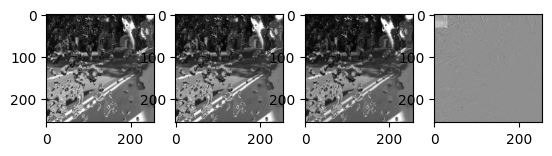

NameError: name 'iou' is not defined

In [25]:
# Get prediction for random image and crop
from random import randint
idx = randint(0, len(val_dataset)-1)
print("Index:", idx)
x, y = val_dataset[idx]
show_channels(x)
plot_prediction(x, y, binary_map=True, binary_threshold=config["threshold"])

In [ ]:
# Get prediction from opened image
image_path = "../../data/derain/ALIGNED_PAIRS/CG_DROPLETS/left_1535201264389466.png"
mask_path = "../../data/derain/ALIGNED_PAIRS/CG_MASKS/left_1535201264389466.png"
from PIL import Image, ImageFilter
image = Image.open(image_path)
mask  = Image.open(mask_path)
x, y = dataset.transform(image, mask)
plot_prediction(x, y, binary_map=False)

In [ ]:
# Clear checkpoints by condition
#clear_checkpoints(config["checkpoint_dir"], condition=lambda ch: ch["train_loss"] >= 0.37, save_last=1)

In [27]:
!ls -la cg_checkpoints

total 9096928
drwxrwsr-x 2 kondrashov students      4096 Aug 16 15:18 .
drwxrwsr-x 8 kondrashov students      4096 Aug 16 15:26 ..
-rw-rw-r-- 1 kondrashov students       627 Aug 15 13:33 nullcheck
-rw-rw-r-- 1 kondrashov students 372617517 Aug  9 16:50 UNetAdamBCEt113v71e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt55v57e0.pt
-rw-rw-r-- 1 kondrashov students 372617205 Aug  9 16:52 UNetAdamBCEt57v55e2.pt
-rw-rw-r-- 1 kondrashov students 372617205 Aug  9 16:51 UNetAdamBCEt60v56e1.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt68v67e2.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt68v68e1.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt77v60e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt82v68e0.pt
-rw-rw-r-- 1 kondrashov students 372610293 Aug  9 14:51 UNetAdamBCEt94v68e0.pt
-rw-rw-r-- 1 kondrashov students 372597045 Aug 15 18:05 UNetHSVBCEt14v14e33.pt
-rw-rw-r-- 1

In [ ]:
!ls final_models

In [ ]:
!cp checkpoints/UNetRGBSBCEt31v31e56.pt final_models

In [ ]:
def modify_dataset():
    # Modify images to make them smoother
    save_dir = '../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7'
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    step = 1
    for path in Path(config["image_dir"]).glob('*.png'):
        image = Image.open(path)
        image = image.filter(ImageFilter.MedianFilter(size = 5))
        new_path = Path(save_dir, path.name)
        image.save(new_path)
        print("Saved", new_path, step)
        step = step + 1